# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [3]:
alpaca_api_key

'PKMR85BRJ9DN60WKDTFQ'

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [7]:
# Calculate the daily roi for the stocks
spy_return = df.SPY.close.pct_change()
agg_return = df.AGG.close.pct_change()
# Display sample data
spy_return.columns = ['Daily_return']
agg_return.columns = ['Daily_return']

In [8]:
#portfolio construction
ret = pd.DataFrame({"spy_return":spy_return,"agg_return":agg_return})
ret.head()


,spy_return,agg_return
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,-0.021730,0.004081
2019-01-04 00:00:00-05:00,0.032521,-0.003037
2019-01-07 00:00:00-05:00,0.007884,-0.002109
2019-01-08 00:00:00-05:00,0.008844,-0.000470


In [9]:
weights = [0.6, 0.4]
portfolio_returns = ret.dot(weights)
portfolio_returns.head()

2019-01-02 00:00:00-05:00         NaN
2019-01-03 00:00:00-05:00   -0.011405
2019-01-04 00:00:00-05:00    0.018298
2019-01-07 00:00:00-05:00    0.003887
2019-01-08 00:00:00-05:00    0.005119
dtype: float64

In [10]:
# Calculate the average roi for the portfolio

avg = portfolio_returns.mean()
print(avg)

0.0007091839668238741


In [11]:
# Compute daily volatility
vol = portfolio_returns.std()

print(vol)


0.004492130504900981


In [20]:
# Save the last day's closing price
#spy_last_price = df.SPY.close[-1]
#agg_last_price = df.AGG.close[-1]
#port_last_price = spy_last_price*0.6 + agg_last_price*0.4
#print(port_last_price)

In [23]:
num_trading_days = 252*30
number_simulations = 500
monte_carlo = pd.DataFrame()

for j in range(number_simulations):
    simulated_prices = [1]
    for i in range(num_trading_days):
        simulated_price = simulated_prices[-1] * (1 + np.random.normal(avg, vol))
        simulated_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
    name = f"{j}th simulation"
    monte_carlo[name] = pd.Series(simulated_prices)

# Print head of DataFrame
monte_carlo.head()

,0th simulation,1th simulation,2th simulation,3th simulation,4th simulation,5th simulation,6th simulation,7th simulation,8th simulation,9th simulation,...,490th simulation,491th simulation,492th simulation,493th simulation,494th simulation,495th simulation,496th simulation,497th simulation,498th simulation,499th simulation
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000030,1.004716,1.005665,1.003348,0.998903,0.995854,0.999951,0.995802,0.998150,0.997383,...,1.002273,1.000250,1.012091,0.998258,1.001793,1.012072,0.998417,1.002991,0.998095,1.002981
2,1.001705,1.007674,1.010667,1.007778,1.008331,0.992872,1.000967,0.999027,0.997276,0.996817,...,0.998910,0.994913,1.017611,0.993882,1.003920,1.016533,0.993470,1.006885,0.995742,1.002304
3,1.001289,1.007498,1.014191,1.013520,1.008887,0.993377,1.006041,0.998361,0.996204,0.991525,...,0.999877,0.985648,1.018050,0.993211,1.008591,1.015805,0.999473,1.004862,0.995763,1.009738
4,0.994351,1.007365,1.012736,1.019640,1.005111,0.996793,1.010751,0.990614,0.995179,0.995182,...,0.993283,0.984766,1.024137,0.992167,1.006319,1.023792,0.999116,1.006541,1.007276,1.013248


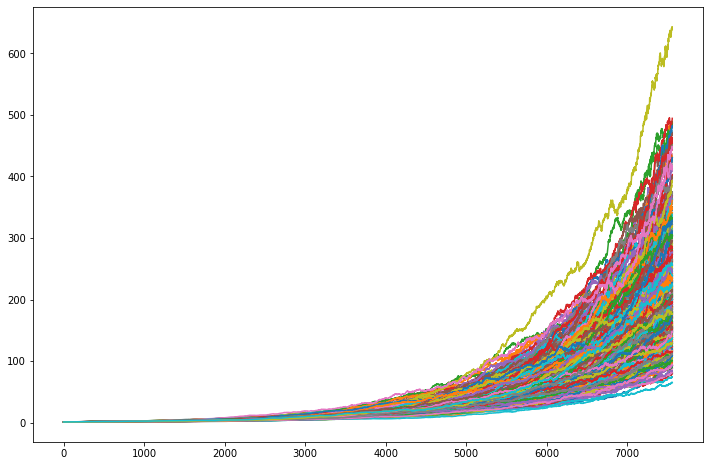

In [24]:
monte_carlo.plot(legend = False,figsize = (12,8))

In [29]:
monte_carlo.tail()

,0th simulation,1th simulation,2th simulation,3th simulation,4th simulation,5th simulation,6th simulation,7th simulation,8th simulation,9th simulation,...,490th simulation,491th simulation,492th simulation,493th simulation,494th simulation,495th simulation,496th simulation,497th simulation,498th simulation,499th simulation
7556,210.108450,275.852555,247.684361,227.348915,182.292302,470.299550,101.392410,87.985930,258.668473,203.555061,...,327.006453,232.879548,176.325234,195.379558,247.097252,203.506049,146.783646,182.805178,176.773299,222.545118
7557,209.649332,276.414056,249.267971,228.174045,182.103444,471.250199,100.512099,88.172659,260.079386,201.590127,...,327.163874,233.246451,177.859760,196.752417,245.491324,203.915410,147.917395,182.998632,176.503906,223.083748
7558,209.988578,275.250148,247.340941,228.924936,182.309148,470.339911,100.442004,88.929663,260.604264,201.497770,...,327.469339,234.073497,177.847730,196.986312,245.534331,206.248727,148.234457,183.977105,177.171028,224.569699
7559,210.050121,275.769822,248.642723,229.354127,182.297557,470.291936,100.513501,88.960545,261.787332,200.312027,...,329.169536,234.107922,178.814292,195.602056,243.658464,205.385618,148.293805,185.048392,177.699721,225.601363
7560,210.715127,276.666627,246.235413,230.633740,183.061043,471.880539,100.388813,88.420266,262.597736,201.130020,...,328.269681,232.216716,179.007901,195.966418,244.830864,204.473858,147.407538,185.035288,176.982839,223.707188


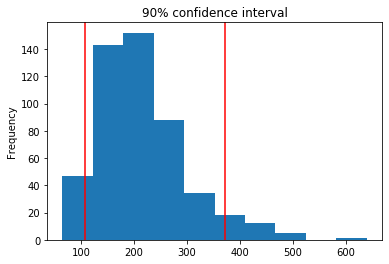

In [28]:
# Visualize the distribution of the ending returns
last_ret = monte_carlo.iloc[-1]
con_int = last_ret.quantile(q = (0.05,0.95))
plt.figure()
last_ret.plot.hist( title="90% confidence interval")
plt.axvline(con_int.iloc[0], color='r')
plt.axvline(con_int.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [30]:
# Compute cumulative returns
projeccted_return = last_ret.quantile(q = (0.1,0.5,0.9))
projeccted_return

0.1    123.840374
0.5    202.620688
0.9    320.696010
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [31]:
# Set initial investment
inc = 20000
# Compute expected portfolio return
portfolio_return = inc * projeccted_return
print(portfolio_return)

0.1    2.476807e+06
0.5    4.052414e+06
0.9    6.413920e+06
Name: 7560, dtype: float64


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [41]:
# Set Plaid's projected income
plaid_income = inc * (1.04)**30
# Calculate the 4% withdrawal for the ending return as retirement income
retie_income  = portfolio_return[0.1]
# Determine if the retirement income meets or exceeds the current projected income
print(plaid_income > retie_income)

False


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [42]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
plaid_income_new = inc*1.5 * (1.04)**30
print(plaid_income_new)

97301.92530082625


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
